In [1]:
import pandas as pd
import janitor
import gc
from utilities.utils import get_fulldata
from utilities.graph_utils import conbarplot
from utilities.graph_utils import save_mpl_fig
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid')
import warnings
warnings.filterwarnings('ignore')

HINDI_NAMES = '../data/hindi_names_religion.csv.gz'

usecols = ['account_no', 'name_of_ryot', '6', '7', '8']
df = (get_fulldata(**{'usecols':usecols})
      # Compute land area (in acres)
      .assign(tt_area_acre=lambda df: df['6']+df['7']/100+df['8']*2.4711)
      .remove_columns(['6', '7', '8'])
      # Get religion via hindi names
      .merge((pd.read_csv(HINDI_NAMES, usecols=['name', 'pred_label'])
              .rename_column('name', 'name_of_ryot')
              .rename_column('pred_label', 'religion')
             ), how='left', on='name_of_ryot', validate='m:1'
            )
      .dropna(subset='religion')
     )
df.shape

(41869305, 4)

In [2]:
df.head(3)

,name_of_ryot,account_no,tt_area_acre,religion
0,मुसमात देवकी ओझा,701010001000008,8.525,not-muslim
1,म.तजमुल हुसैन,701010001000003,0.560,muslim
2,म.तजमुल हुसैन,701010001000003,0.000,muslim


In [3]:
nplots_by_account = (df
                     .groupby(['account_no', 'religion']).size().reset_index()
                     .rename_column(0, 'nplots')
                    )
print(f'{len(nplots_by_account)=:,}')
print(nplots_by_account.head(3))

len(nplots_by_account)=12,126,512
        account_no    religion  nplots
0  101010273000001  not-muslim       2
1  101010273000002  not-muslim       8
2  101010273000003  not-muslim       1


In [4]:
landarea_by_account = (df
                       .groupby(['account_no', 'religion'])
                       .sum().reset_index()
                       .query('tt_area_acre>0')
                      )
print(f'{len(landarea_by_account)=:,}')
print(landarea_by_account.head(3))

len(landarea_by_account)=12,031,306
        account_no    religion  tt_area_acre
0  101010273000001  not-muslim         0.585
1  101010273000002  not-muslim         1.545
2  101010273000003  not-muslim         0.080


### Aggregate numbers

In [5]:
tt_bihar_pop = 103_998_500  # https://en.wikipedia.org/wiki/Bihari_Muslims#Distribution_by_district
pct_bihar_muslim = .169 

In [30]:
# Percentage of Biharis owning plots
n_acct_holders = df.account_no.nunique()
pct_plot_owned_biharis = 100 * (n_acct_holders/tt_bihar_pop)
print(f"Percentage of Biharis owning plots: {pct_plot_owned_biharis:.1f}%")

Percentage of Biharis owning plots: 11.7%


In [31]:
# Percentage of Muslim owning plots
n_muslim_owning_plot = df.query('religion=="muslim"').account_no.nunique()
n_muslim = pct_bihar_muslim * tt_bihar_pop 
pct_muslim_owning_land = 100 * (n_muslim_owning_plot/n_muslim)
print(f"Percentage of Muslim owning plots: {pct_muslim_owning_land:.1f}%")

Percentage of Muslim owning plots: 9.8%


In [32]:
print(f"{n_muslim_owning_plot=:,}")

n_muslim_owning_plot=1,721,595


In [33]:
# Percentage of Hindus owning plots
n_hindus_owning_plot = df.query('religion=="not-muslim"').account_no.nunique()
n_hindus = (1-pct_bihar_muslim) * tt_bihar_pop 
pct_hindus_owning_land = 100 * (n_hindus_owning_plot/n_hindus)
print(f"Percentage of Hindus owning plots: {pct_hindus_owning_land:.1f}%")

Percentage of Hindus owning plots: 12.0%


In [34]:
print(f"{n_hindus_owning_plot=:,}")

n_hindus_owning_plot=10,404,917


In [35]:
# Percentage of plots owned by muslims
plots_owned_by_muslims = nplots_by_account.query('religion=="muslim"')['nplots'].sum()
tt_plots = nplots_by_account.nplots.sum()
pct_plot_owned_by_muslims = 100*(plots_owned_by_muslims/tt_plots)
print(f"Percentage of plots owned by muslims: {pct_plot_owned_by_muslims:.1f}%")

Percentage of plots owned by muslims: 11.7%


In [41]:
muslim_landarea = landarea_by_account.query('religion=="muslim"')['tt_area_acre'].mean()
hindu_landarea = landarea_by_account.query('religion=="not-muslim"')['tt_area_acre'].mean()

In [40]:
muslim_landarea

35.02239975401549

In [42]:
hindu_landarea

53.529690640683256

In [43]:
hindu_landarea - muslim_landarea

18.507290886667768

### Number of plots

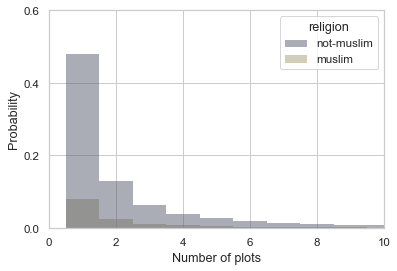

In [10]:
# Truncated > 90th percentile
sns.histplot(data=nplots_by_account, x="nplots", 
             hue='religion',
             discrete=True,
             stat="probability", 
             palette='cividis'
            )
plt.xlabel('Number of plots')
plt.yticks([0,.2,.4,.6])
plt.xlim(0, 10)
save_mpl_fig('../figures/religion_number_plots')

-0.7077418626283811


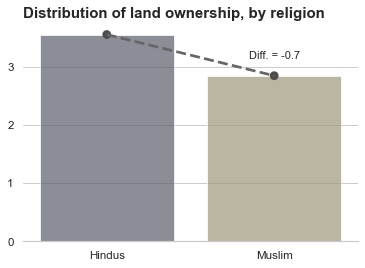

In [11]:
conbarplot(x='religion', y='nplots', data=nplots_by_account, 
           grouplab='religion', groups=['not-muslim', 'muslim'],
           xticklabels=['Hindu', 'Muslim'],
           title='Distribution of land ownership, by religion'
          )    
save_mpl_fig('../figures/religion_barplot_plots')

### Land area

In [ ]:
landarea_by_account = (df
                       .groupby(['account_no', 'religion'])
                       .sum().reset_index()
                       .query('tt_area_acre>0')
                      )
del df
gc.collect()
print(f'{len(landarea_by_account)=:,}')
print(landarea_by_account.head(3))

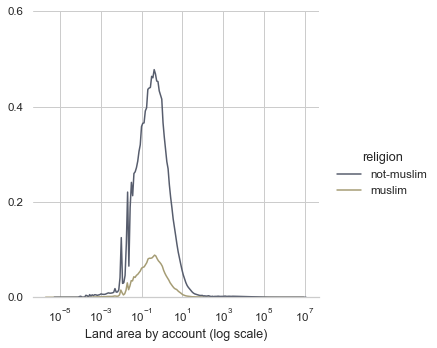

In [12]:
sns.displot(data=landarea_by_account,
            x='tt_area_acre',
            kind='kde',
            hue='religion',
            log_scale=True,
            palette='cividis',
            cut=0
            )
plt.ylabel('')
plt.xlabel('Land area by account (log scale)')
plt.yticks([0,.2,.4,.6])
sns.despine(left=True)
save_mpl_fig('../figures/religion_plot_area')

-18.507290886667768


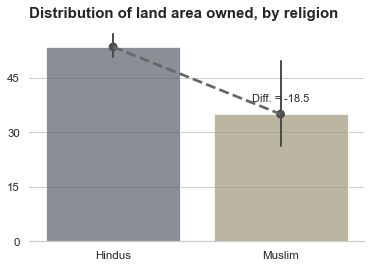

In [13]:
conbarplot(x='religion', y='tt_area_acre', data=landarea_by_account, 
           grouplab='religion', groups=['not-muslim', 'muslim'],
           xticklabels=['Hindu', 'Muslim'],
           title='Distribution of land area owned, by religion'
          )    
save_mpl_fig('../figures/religion_barplot_plotarea')